In [17]:
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from processing_functions import (ppt_id, create_epochs, freq_ind, create_numeric_labels, relative_band_power,
    absolute_band_power)


Function for obtaining participant id (as a string) from their index. The participants are 1-indexed in the data and I'm choosing to respect that here. The resulting string is used to load in the raw data and can be used as a primary key in the participants table.

In [134]:
def ppt_id(i):
    return 'sub-' + str(i).zfill(3)

In [135]:
ppt_id(40)

'sub-040'

Loading in a participant using mne. I defaulted to 1 here. In the full feature extraction setup we would load and process the participants one at a time in a loop over all participants. 

In [30]:
ppt = 40
raw_data = mne.io.read_raw_eeglab('data/ds004504/derivatives/' + ppt_id(ppt)
                                  + '/eeg/' + ppt_id(ppt) + '_task-eyesclosed_eeg.set', preload = True)

/var/folders/42/2zjv5vys3693nls8j787kc2c0000gn/T/ipykernel_2497/1914673824.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab('data/ds004504/derivatives/' + ppt_id(ppt)


Description of the raw data. The most important extra bit of info we need from this is the sampling frequency, which we save in sample_freq. 

In [13]:
raw_data

<RawEEGLAB | sub-001_task-eyesclosed_eeg.set, 19 x 299900 (599.8 s), ~43.5 MB, data loaded>

In [8]:
epoch_length = 2000
overlap_ratio = 0.5
freq_bands = np.array([0.5,4.0,8.0,13.0,25.0,45.0])
sample_freq = 500 #hertz

Exporting to a pandas dataframe. The units are µV, which are the default export unit for eegs listed in the mne documentation. Since the relative band power that we eventually compute is a unitless ratio, the units don't actually matter in the end for the classifiers, but they are important for plotting. 

In [31]:
export = raw_data.to_data_frame()
ppt_array = export.iloc[:,range(1,len(export.columns))].values
ppt_epochs = create_epochs(ppt_array,epoch_length,overlap_ratio)
freqs, ppt_psd  = welch(ppt_epochs,fs=sample_freq, axis=1)
ppt_rbp = absolute_band_power(ppt_psd,freqs,freq_bands)


In [37]:
ppt_rbp[0][4]

array([ 5.98652932,  8.09013129,  4.45420145,  5.81268039,  3.79655826,
        5.15540454,  4.34419895,  4.98046813,  5.36875571,  5.5996647 ,
       11.67672006,  6.76973948, 11.91825187, 13.49258004,  5.18174434,
        5.62859966,  4.43221531,  3.98540666,  4.55107642])

Next bit isn't used in this notebook, but is handy for the future. I'm going to convert this table to an array and delete the original table, which would cause the loss of the channel name information. The code below saves the channel names in a python dictionary for future use. They are 0-indexed to match the indices in the numpy array we are about to create. 

In [136]:
channels = {}
for i in range(len(export.columns)-1):
    channels[i] = export.columns[i+1]

In [137]:
channels

{0: 'Fp1',
 1: 'Fp2',
 2: 'F3',
 3: 'F4',
 4: 'C3',
 5: 'C4',
 6: 'P3',
 7: 'P4',
 8: 'O1',
 9: 'O2',
 10: 'F7',
 11: 'F8',
 12: 'T3',
 13: 'T4',
 14: 'T5',
 15: 'T6',
 16: 'Fz',
 17: 'Cz',
 18: 'Pz'}

Extracting the numpy array we need from the dataframe. The time column isn't needed for our analysis so I dropped it, since the time data is contained in the sampling frequency.

In [26]:
ppt_array = export.iloc[:,range(1,len(export.columns))].values
ppt_array

array([[-33.71668625, -25.14232635, -10.50162601, ..., -16.64021873,
        -15.98962975, -15.89824486],
       [-28.18910027, -20.73062134, -10.805439  , ..., -14.8037262 ,
        -14.48227692, -14.14704514],
       [-22.79613876, -16.69319534, -11.65396404, ..., -13.29928589,
        -13.11245918, -12.64957714],
       ...,
       [  7.80744267,  11.26339245,  11.25347614, ...,  10.19259453,
          7.03979826,   5.74603224],
       [  3.91629434,   7.11532831,   8.1601038 , ...,   7.10190392,
          5.04175997,   4.06592989],
       [ -0.34640756,   2.75438499,   4.52085495, ...,   3.56178188,
          2.26020527,   1.59326601]])

Checking the shape of our array.

In [138]:
ppt_array.shape

(299900, 19)

Deleting the mne raw object and the pandas dataframe since they are no longer needed and take up a lot of memory. 

In [29]:
del raw_data
del export

We need to reference the participants table in order to know what class a given participant belongs to. I loaded that table in below. 

In [139]:
ppt_diagnostics = pd.read_csv('participants.tsv',sep='\t')

A sample from the table. Age and gender are self-explanatory. The classes in the Group column are 'A' (Alzheimers), 'F' (Frontotemporal Dementia), and 'C' (Healthy). The MMSE score is a mini-mental state examination used to screen for cognitive impairment. 

In [140]:
ppt_diagnostics.sample(5)

,participant_id,Gender,Age,Group,MMSE
12,sub-013,F,64,A,20
62,sub-063,M,66,C,30
36,sub-037,M,57,C,30
86,sub-087,M,73,F,24
85,sub-086,M,49,F,26


We can look at an individual participant with iloc. 

In [38]:
ppt_diagnostics.iloc[ppt-1]

participant_id    sub-001
Gender                  F
Age                    57
Group                   A
MMSE                   16
Name: 0, dtype: object

Class information can be obtained by restricting to the group column. 

In [41]:
ppt_class = ppt_diagnostics['Group'].iloc[ppt-1]
ppt_class

'A'

When creating epochs we need to specify the length of the epoch and the amount of overlap between epochs. I've specified 2000 for the length (which is 4 seconds at a sampling frequency of 500 Hz) and 0.5 for the overlap ratio so that there is a 2 second overlap between successive epochs. 

In [141]:
epoch_length = 2000
overlap_ratio = 0.5

The following function creates the epochs as specified. It returns a numpy array of shape (number of epochs) x (epoch_length) x (number of channels).

In [116]:
def create_epochs(ppt_array,epoch_length,overlap_ratio):
    num_rows = ppt_array.shape[0]
    step_size = int((1-overlap_ratio)*epoch_length)
    epoch_list = []
    for i in range(int(num_rows/step_size)):
        if step_size*i+epoch_length <= num_rows: #leave out last epoch if it would have length less than epoch_length
            epoch_list.append(ppt_array[step_size*i:step_size*i+epoch_length])
    return np.array(epoch_list)

In [117]:
ppt_epochs = create_epochs(ppt_array,epoch_length,overlap_ratio)

In [118]:
ppt_epochs.shape

(298, 2000, 19)

Next we use the welch function from scipy.signal to obtain an estimate for the power spectral density of each epoch. The first argument is our epoch array, the second argument fs is the sampling frequency (500 Hz), the third argument nperseg is just epoch_length (the total number of measurements in the time series), and the last argument specifies that the psd should be measured along the time series axis (axis = 1). The function returns an array of sample frequencies (which we catch in freqs) and an array of estimates for the psd at each of those frequencies. Keep in mind that the units of the input are µV, so the output units are actually µV^2/Hz (as in their Figure 3).

In [142]:
freqs, ppt_psd  = welch(ppt_epochs,fs=sample_freq,nperseg=epoch_length,axis=1)

The freqs array is just an evenly spaced set of numbers from 0 to 250, with spacing 0.25. This is very much overkill since we only need this up to 45 Hz. 

In [143]:
freqs

array([  0.  ,   0.25,   0.5 , ..., 249.5 , 249.75, 250.  ])

In [144]:
ppt_psd

array([[[5.87018109e+02, 5.80310134e+02, 4.88845407e+02, ...,
         5.03915555e+02, 5.04537442e+02, 5.11949827e+02],
        [3.04804269e+03, 3.10922366e+03, 3.11845767e+03, ...,
         2.91274523e+03, 2.89990575e+03, 2.89079020e+03],
        [1.65773748e+03, 1.89042531e+03, 1.91961486e+03, ...,
         1.76110814e+03, 1.68301612e+03, 1.65931141e+03],
        ...,
        [1.05465662e-10, 1.04905727e-10, 1.28128913e-10, ...,
         1.34507558e-10, 1.57482155e-10, 1.68256933e-10],
        [7.04400252e-10, 6.67124156e-10, 6.98533530e-10, ...,
         6.24821953e-10, 6.79651644e-10, 6.92704980e-10],
        [4.09683302e-10, 3.84131385e-10, 3.68019523e-10, ...,
         3.23690175e-10, 3.32367164e-10, 3.17732047e-10]],

       [[7.98211882e+00, 3.53520726e+00, 3.29062034e-01, ...,
         4.77545661e-03, 1.76138971e+00, 3.50989162e+00],
        [2.78084387e+03, 2.56762447e+03, 2.66039562e+03, ...,
         2.39768426e+03, 2.52457919e+03, 2.49862055e+03],
        [2.89917100e+03, 

In [145]:
print(freqs.shape)
print(ppt_psd.shape)

(1001,)
(298, 1001, 19)


Plotting ppt_psd against freqs for 1 channel and 1 epoch as an example. This one is concentrated pretty close to 0 so I'll zoom in there. 

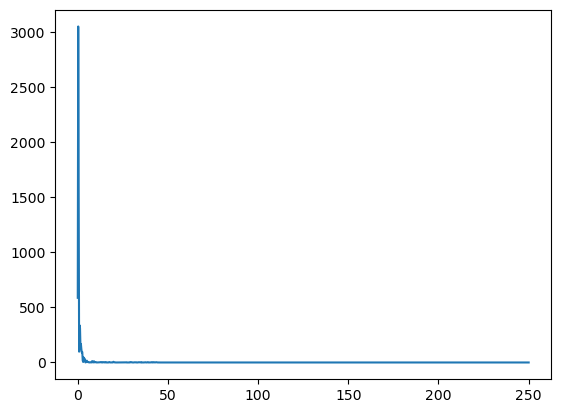

In [147]:
plt.plot(freqs,ppt_psd[0,:,0])

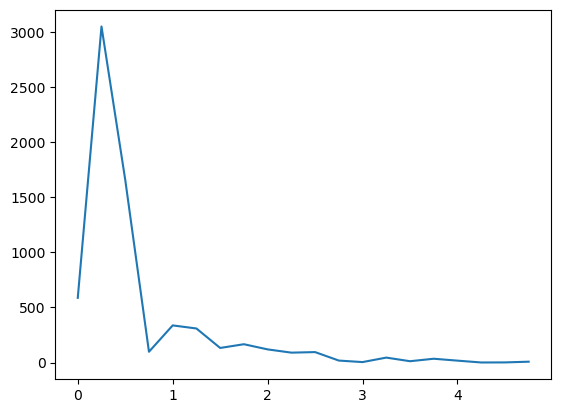

In [146]:
plt.plot(freqs[:20],ppt_psd[0,:20,0])

Specifying the cutoffs for the frequency bands. The range 0.5-4 Hz is called the Delta range, 4-8 Hz is Theta, 8-13 is Alpha, 13-25 is Beta, 25-45 is Gamma. 

In [111]:
freq_bands = np.array([0.5,4.0,8.0,13.0,25.0,45.0])

A function for obtaining the corresponding indices to access these frequency bands in the freqs array. 

In [98]:
def freq_ind(freqs,freq_bands):
    indices = []
    for i in range(len(freq_bands)):
        indices.append(np.argmin(np.where(freqs >= freq_bands[i],freqs,np.inf)))
    return indices

Testing the function.

In [99]:
indices = freq_ind(freqs,freq_bands)

In [110]:
for i in range(len(indices)):
    print(freqs[indices[i]])

0.5
4.0
8.0
13.0
25.0
45.0


To obtain the relative band power (RBP) of each frequency band we integrate the psd over each of the five frequency bands and divide that by the integral of the psd over the full 0.5-45 Hz band. Since we are taking a ratio the increment between frequencies in freqs (which is 0.25 with our current values) cancels out on the top and bottom with these integrals so we can just sum the values of the psd in these ranges. The keepdims = True argument is required to take advantage of numpy's broadcasting to make this task a bit easier. In the return line I get rid of the 1-dimensional axis from the keepdims bit and then rearrange the axes so that the epoch is the leading axis. For training we would also flatten the (5,19) part into a single dimension.   

In [148]:
def relative_band_power(ppt_psd,freqs,freq_bands):
    indices = freq_ind(freqs,freq_bands)
    total_power = np.sum(ppt_psd[:,indices[0]:indices[-1],:],axis=1,keepdims=True)
    relative_bands_list = []
    for i in range(len(indices)-1):
        relative_bands_list.append(np.sum(ppt_psd[:,indices[i]:indices[i+1],:],axis=1,keepdims=True)/total_power)
    return np.transpose(np.squeeze(np.array(relative_bands_list)),(1,0,2))

In [149]:
ppt_rbp = relative_band_power(ppt_psd,freqs,freq_bands)

In [150]:
ppt_rbp.shape

(298, 5, 19)

In [151]:
ppt_rbp

array([[[0.92022716, 0.92929837, 0.9373573 , ..., 0.93573791,
         0.9400835 , 0.94340537],
        [0.02260088, 0.02874346, 0.03336272, ..., 0.03449178,
         0.03218205, 0.02876399],
        [0.01645015, 0.01335824, 0.01140767, ..., 0.01266795,
         0.01215727, 0.0120701 ],
        [0.01698087, 0.01318902, 0.00920148, ..., 0.01068129,
         0.00991135, 0.01068838],
        [0.02374093, 0.0154109 , 0.00867084, ..., 0.00642107,
         0.00566583, 0.00507216]],

       [[0.91278718, 0.91729242, 0.93917855, ..., 0.91661161,
         0.90949609, 0.90558457],
        [0.04326029, 0.04882613, 0.04039459, ..., 0.06247327,
         0.07170402, 0.07101357],
        [0.01178527, 0.0113907 , 0.00929586, ..., 0.00976025,
         0.00796595, 0.01031576],
        [0.01494737, 0.01093454, 0.00678994, ..., 0.00693464,
         0.00671755, 0.00992995],
        [0.0172199 , 0.01155621, 0.00434107, ..., 0.00422023,
         0.00411638, 0.00315615]],

       [[0.87503347, 0.87416409, 0.8